### Deriving Greeks from option spreads
Imports data from `adjusted_options` although raw data works fine as well

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import multiprocessing
from multiprocessing.pool import Pool
from pathlib import Path

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [2]:
ticker = "AAPL"
option_data_path = "data/adjusted_options/"
default_save_path = "data/greeks/"

**Load adjusted options data**

In [3]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, (ticker + ".csv"))))
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + ticker + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, ticker)) + ".csv")

In [4]:
call_options = options_df[options_df["type"] == "call"]
put_options = options_df[options_df["type"] == "put"]

Delta ($\Delta$) at a certain strike price (K) is calculated based off the forward and backward change in strike price. For example, for K=20, the delta at K=19.5 is calculated by taking the slope between K=19 and K=20. Likewise, Delta at K=20.5 is based off ask/bid prices at K=20 and K=21.

Note that the assumption of midpoint is built upon the existence of a monotonic Delta function, which is realistic. For example, the Delta of long calls should decrease from 1 (very ITM) to 0 (very OTM).

The same logic is applied for calculating Gamma ($\Gamma$).

Since calculated Delta and Gamma values are midpoints between their respective strike prices, the greek values for the original option strikes are **linearly** interpolated.

Since Delta and Gamma are dependent on the price of the underlying, by calculating the amount by which the option is ITM or OTM (dividend adjusted), we create a universal "moneyness" feature.
    - POSITIVE -> ITM
    - NEGATIVE -> OTM

In [5]:
def calc_delta_gamma(input_df, is_call):
    # Calculating Delta
    temp_delta_df = input_df[["strike price", "ask price", "bid price"]].diff()[1:].reset_index(drop=True)
    temp_delta_df = temp_delta_df.rename(columns={"strike price": "asset change",
                                                  "ask price": "ask change",
                                                  "bid price": "bid change"})
    # Change in asset price is negative of change in  strike price
    temp_delta_df["asset change"] = -temp_delta_df["asset change"]
    # Strike price for delta to be midpoint between the two options
    temp_delta_df["strike price"] = (input_df["strike price"][:-1].reset_index(drop=True) +
                                     input_df["strike price"][1:].reset_index(drop=True)) / 2
    temp_delta_df["ask"] = temp_delta_df["ask change"] / (temp_delta_df["asset change"])
    temp_delta_df["bid"] = temp_delta_df["bid change"] / (temp_delta_df["asset change"])
    # Add type
    temp_delta_df["type"] = "slope midpoint"

    # Calculating Gamma
    temp_gamma_df = temp_delta_df[["strike price", "ask", "bid"]].diff()[1:].reset_index(
        drop=True)
    temp_gamma_df = temp_gamma_df.rename(columns={"strike price": "asset change",
                                                  "ask": "ask change",
                                                  "bid": "bid change"})
    temp_gamma_df["asset change"] = -temp_gamma_df["asset change"]
    temp_gamma_df["strike price"] = (temp_delta_df["strike price"][:-1].reset_index(drop=True) +
                                     temp_delta_df["strike price"][1:].reset_index(drop=True)) / 2
    temp_gamma_df["ask"] = temp_gamma_df["ask change"] / temp_gamma_df["asset change"]
    temp_gamma_df["bid"] = temp_gamma_df["bid change"] / temp_gamma_df["asset change"]
    # Add type
    temp_gamma_df["type"] = "slope midpoint"

    # Add on strike prices of actual options
    temp_delta_df = temp_delta_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])
    temp_gamma_df = temp_gamma_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])

    # Sort order of rows, ignore_index re-indexes for loop below
    temp_delta_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)
    temp_gamma_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)

    for temp_df in [temp_delta_df, temp_gamma_df]:
        # Estimate missing delta/gamma of actual options
        # Special cases
        if np.isnan(temp_df.loc[0, "ask"]):
            # Find FIRST entry available
            temp_df.loc[0, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[0, ["ask", "bid"]] = completed_temp_df.loc[0, ["ask", "bid"]]
        if np.isnan(temp_df.loc[temp_df.shape[0] - 1, "ask"]):
            # Find LAST entry available
            temp_df.loc[temp_df.shape[0] - 1, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[temp_df.shape[0] - 1, ["ask", "bid"]] = completed_temp_df.loc[
                completed_temp_df.index[-1], ["ask", "bid"]]
        # Everything in the middle
        for n in range(temp_df.shape[0]):
            if not np.isnan(temp_df.loc[n, "ask"]):
                continue
            else:
                temp_df.loc[n, "type"] = "interpolation"
                # Find the next entry that is not NaN
                forward_shift = 1
                while np.isnan(temp_df.loc[n + forward_shift, "ask"]):
                    forward_shift += 1
                prev_distance = float(temp_df.loc[n, "strike price"] -
                                      temp_df.loc[n - 1, "strike price"])
                next_distance = float(temp_df.loc[n + forward_shift, "strike price"] -
                                      temp_df.loc[n, "strike price"])
                temp_df.loc[n, ["ask", "bid"]] = (((next_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n - 1, ["ask", "bid"]]) +
                                                  ((prev_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n + forward_shift, ["ask", "bid"]]))
        # Add dates
        temp_df[["date", "expiration date"]] = [np.unique(input_df["date"])[0],
                                                np.unique(input_df["expiration date"])[0]]
        # Amount by which options are ITM or OTM (div adjusted)
        temp_df["moneyness"] = ((np.unique(input_df["closing price"])[0] -
                                 np.unique(input_df["date div"])[0]) -
                                (temp_df["strike price"] -
                                 np.unique(input_df["exp date div"])[0]))
        # for calls, moneyness is (closing - strike); opposite for puts
        if not is_call:
            temp_df["moneyness"] = -temp_df["moneyness"]

        # Drop intermediate columns
        temp_df.drop(["asset change", "ask change", "bid change"], axis=1, inplace=True)

    return [temp_delta_df, temp_gamma_df]

In [6]:
my_pool = Pool(multiprocessing.cpu_count())
is_call = True
call_delta_df = pd.DataFrame()
call_gamma_df = pd.DataFrame()
put_delta_df = pd.DataFrame()
put_gamma_df = pd.DataFrame()

for my_df in [call_options, put_options]:
    delta_df = pd.DataFrame()
    gamma_df = pd.DataFrame()
    input_list = list()
    delta_list = list()
    gamma_list = list()
    if is_call:
        option_type = "call"
    else:
        option_type = "put"

    for my_day in set(my_df["date"]):
        day_df = my_df[my_df["date"] == my_day]
        exp_dates = set(day_df["expiration date"])
        for exp_day in exp_dates:
            input_list.append((day_df[day_df["expiration date"] == exp_day], is_call))
    print(f"done creating {option_type} inputs!")

    pool_results = my_pool.starmap(calc_delta_gamma, input_list)
    print(f"done calculating {option_type} delta and gamma values!")

    # Sort data into lists
    for n in range(len(pool_results)):
        delta_list.append(pool_results[n][0])
        gamma_list.append(pool_results[n][1])

    # Concat each list to a DataFrame
    delta_df = pd.concat(delta_list)
    gamma_df = pd.concat(gamma_list)

    # Rearrange column order
    delta_df = delta_df[["date", "expiration date", "strike price",
                         "moneyness", "ask", "bid", "type"]]
    gamma_df = gamma_df[["date", "expiration date", "strike price",
                         "moneyness", "ask", "bid", "type"]]

    delta_df.sort_values(by=["date", "expiration date"],
                         inplace=True, ignore_index=True)

    gamma_df.sort_values(by=["date", "expiration date"],
                         inplace=True, ignore_index=True)

    if is_call:
        call_delta_df = delta_df
        call_gamma_df = gamma_df
        is_call = False
    else:
        put_delta_df = delta_df
        put_gamma_df = gamma_df

    print(f"finished {option_type} options!")

done creating call inputs!
done calculating call delta and gamma values!
finished call options!
done creating put inputs!
done calculating put delta and gamma values!
finished put options!


In [7]:
print("Delta of Call Options")
print(call_delta_df.head())
print("Gamma of Call Options")
print(call_gamma_df.head())

Delta of Call Options
         date expiration date  strike price  moneyness  ask  bid  \
0  2016-01-04      2016-01-08        15.000  11.345525  1.0  1.0   
1  2016-01-04      2016-01-08        15.625  10.720525  1.0  1.0   
2  2016-01-04      2016-01-08        16.250  10.095525  1.0  1.0   
3  2016-01-04      2016-01-08        16.875   9.470525  1.0  1.0   
4  2016-01-04      2016-01-08        17.500   8.845525  1.0  1.0   

             type  
0   interpolation  
1  slope midpoint  
2   interpolation  
3  slope midpoint  
4   interpolation  
Gamma of Call Options
         date expiration date  strike price  moneyness     ask           bid  \
0  2016-01-04      2016-01-08         15.00  11.345525 -0.0000 -0.000000e+00   
1  2016-01-04      2016-01-08         16.25  10.095525 -0.0000 -0.000000e+00   
2  2016-01-04      2016-01-08         17.50   8.845525 -0.0000 -5.329071e-16   
3  2016-01-04      2016-01-08         18.75   7.595525 -0.0000  5.329071e-16   
4  2016-01-04      2016-01-

Visualization of Delta and Gamma values for a specific date and expiration date.

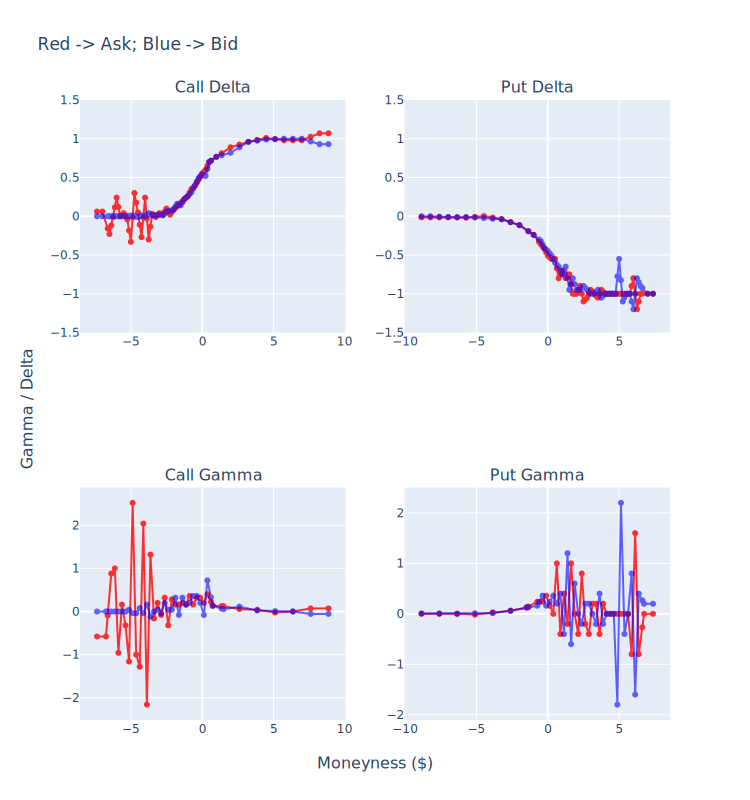

In [8]:
plot_date = datetime.date(2016, 1, 4)
plot_exp_date = datetime.date(2016, 1, 22)

viz_call_delta = call_delta_df[(call_delta_df["date"] == plot_date) &
                               (call_delta_df["expiration date"] == plot_exp_date)]

viz_call_gamma = call_gamma_df[(call_gamma_df["date"] == plot_date) &
                               (call_gamma_df["expiration date"] == plot_exp_date)]

viz_put_delta = put_delta_df[(put_delta_df["date"] == plot_date) &
                             (put_delta_df["expiration date"] == plot_exp_date)]

viz_put_gamma = put_gamma_df[(call_gamma_df["date"] == plot_date) &
                             (call_gamma_df["expiration date"] == plot_exp_date)]

if not viz_call_delta.shape[0]:
    raise Exception("Date and/or expiration date combo not valid!")

dg_fig = make_subplots(rows=2, cols=2,
                       x_title="Moneyness ($)",
                       y_title="Gamma   /   Delta",
                       subplot_titles=["Call Delta", "Put Delta",
                                       "Call Gamma", "Put Gamma"])
n_iter = 1
[nrow, ncol] = [1, 1]

for n in [viz_call_delta, viz_put_delta, viz_call_gamma, viz_put_gamma]:
    if n_iter == 2:
        [nrow, ncol] = [1, 2]
    elif n_iter == 3:
        [nrow, ncol] = [2, 1]
    elif n_iter == 4:
        [nrow, ncol] = [2, 2]
    n_iter += 1
    dg_fig.add_trace(go.Scatter(x=n["moneyness"],
                                y=n["ask"],
                                mode='lines+markers',
                                opacity=0.8,
                                marker_color="red",
                                showlegend=False),
                     row=nrow, col=ncol)

    dg_fig.add_trace(go.Scatter(x=n["moneyness"],
                                y=n["bid"],
                                mode='lines+markers',
                                opacity=0.6,
                                marker_color="blue",
                                showlegend=False),
                     row=nrow, col=ncol)

dg_fig.update_layout(title_text="Red -> Ask; Blue -> Bid")
dg_fig.update_yaxes(row=1, range= [-1.5, 1.5])
dg_fig.show("svg", width=750, height=800)

**Export data**

In [9]:
Path(default_save_path).mkdir(exist_ok=True)

for option_type in ["calls", "puts"]:
    if option_type == "calls":
        delta_df = call_delta_df
        gamma_df = call_gamma_df
    else:
        delta_df = put_delta_df
        gamma_df = put_gamma_df

delta_df.to_csv(path_or_buf=f"{default_save_path}{ticker}_{option_type}_delta.csv", index=False)
gamma_df.to_csv(path_or_buf=f"{default_save_path}{ticker}_{option_type}_gamma.csv", index=False)
